In [ ]:
import os
import json
import numpy as np
import cv2
from pathlib import Path

NB_DIR = Path().resolve()
ROOT = NB_DIR.parent # project root

print("Notebook directory:", NB_DIR)
print("ROOT:", ROOT)

IMG_DIR = ROOT / "data/images"
ANN_DIR = ROOT / "data/arrow_data/arrow_annotations2"
OUT_IMG_DIR = ROOT / "data/arrow_data/images_out"
OUT_HM_DIR = ROOT / "data/arrow_data/heatmaps"

os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(OUT_HM_DIR, exist_ok=True)

SIGMA = 50          # gaussian size
# final unified resolution for training
TARGET_W = 384     # width
TARGET_H = 640     # height

Notebook directory: /Users/jleto/LocalProjects/rev_vision/notebooks
ROOT: /Users/jleto/LocalProjects/rev_vision


In [44]:
# Converts LabelMe point annotations into resized training images and
# per-arrow Gaussian heatmaps (left, middle, right) saved as .npy files.

def gaussian_heatmap(h, w, cx, cy, sigma):
    X, Y = np.meshgrid(np.arange(w), np.arange(h))
    return np.exp(-((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2))

for file in os.listdir(ANN_DIR):
    if not file.endswith(".json"):
        continue

    json_path = os.path.join(ANN_DIR, file)
    with open(json_path, "r") as f:
        data = json.load(f)

    img_filename = os.path.basename(data["imagePath"])
    img_path = os.path.join(IMG_DIR, img_filename)

    if not os.path.exists(img_path):
        print("Missing image:", img_path)
        continue

    img = cv2.imread(img_path)
    H, W = img.shape[:2]

    img_resized = cv2.resize(img, (TARGET_W, TARGET_H), interpolation=cv2.INTER_AREA)
    cv2.imwrite(os.path.join(OUT_IMG_DIR, img_filename), img_resized)
    print("Saved:", img_filename)

    hm_left   = np.zeros((TARGET_H, TARGET_W), dtype=np.float32)
    hm_center = np.zeros((TARGET_H, TARGET_W), dtype=np.float32)
    hm_right  = np.zeros((TARGET_H, TARGET_W), dtype=np.float32)

    # compute scale factors
    sx = TARGET_W / W
    sy = TARGET_H / H

    for shape in data["shapes"]:
        label = shape["label"]
        x, y = shape["points"][0]

        rx = x * sx
        ry = y * sy

        # clamp to stay inside final image
        rx = min(max(rx, 0), TARGET_W - 1)
        ry = min(max(ry, 0), TARGET_H - 1)

        if label == "left":
            hm_left += gaussian_heatmap(TARGET_H, TARGET_W, rx, ry, SIGMA)
        elif label == "middle":
            hm_center += gaussian_heatmap(TARGET_H, TARGET_W, rx, ry, SIGMA)
        elif label == "right":
            hm_right += gaussian_heatmap(TARGET_H, TARGET_W, rx, ry, SIGMA)

    heatmap = np.stack([hm_left, hm_center, hm_right], axis=-1)
    heatmap /= heatmap.max(axis=(0,1), keepdims=True) + 1e-8

    out_name = file.replace(".json", ".npy")
    np.save(os.path.join(OUT_HM_DIR, out_name), heatmap)

    print("Saved:", out_name)

Saved: frame_0007.png
Saved: frame_0007.npy
Saved: frame_0046.png
Saved: frame_0046.npy
Saved: frame_0011.png
Saved: frame_0011.npy
Saved: frame_0085.png
Saved: frame_0085.npy
Saved: frame_0093.png
Saved: frame_0093.npy
Saved: frame_0089.png
Saved: frame_0089.npy
Saved: frame_0066.png
Saved: frame_0066.npy
Saved: frame_0027.png
Saved: frame_0027.npy
Saved: frame_0070.png
Saved: frame_0070.npy
Saved: frame_0071.png
Saved: frame_0071.npy
Saved: frame_0026.png
Saved: frame_0026.npy
Saved: frame_0088.png
Saved: frame_0088.npy
Saved: frame_0067.png
Saved: frame_0067.npy
Saved: frame_0092.png
Saved: frame_0092.npy
Saved: frame_0010.png
Saved: frame_0010.npy
Saved: frame_0006.png
Saved: frame_0006.npy
Saved: frame_0060.png
Saved: frame_0060.npy
Saved: frame_0037.png
Saved: frame_0037.npy
Saved: frame_0076.png
Saved: frame_0076.npy
Saved: frame_0001.png
Saved: frame_0001.npy
Saved: frame_0056.png
Saved: frame_0056.npy
Saved: frame_0040.png
Saved: frame_0040.npy
Saved: frame_0083.png
Saved: fra

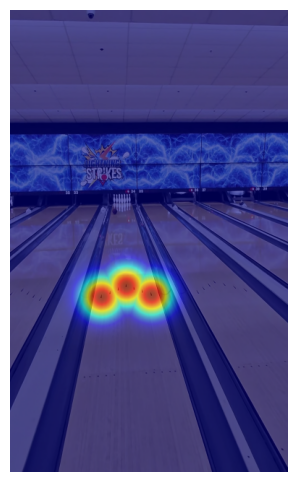

In [45]:
# Visual sanity-check: overlays a generated heatmap onto its resized image
from matplotlib import pyplot as plt

alpha = 0.6  # opacity of the heatmap overlay

for hm_file in os.listdir(OUT_HM_DIR):
    if not hm_file.endswith(".npy"):
        continue

    heatmap = np.load(os.path.join(OUT_HM_DIR, hm_file))

    img_file = hm_file.replace(".npy", ".png")
    img_path = os.path.join(OUT_IMG_DIR, img_file)

    if not os.path.exists(img_path):
        print("Missing:", img_file)
        continue

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    combined = heatmap.max(axis=2)
    combined = combined / (combined.max() + 1e-6)
    combined = (combined * 255).astype(np.uint8)

    colored = cv2.applyColorMap(combined, cv2.COLORMAP_JET)
    colored = cv2.cvtColor(colored, cv2.COLOR_BGR2RGB)

    overlay = (img * (1 - alpha) + colored * alpha).astype(np.uint8)

    plt.figure(figsize=(8,6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

    break  # only show one

In [46]:
from torch.utils.data import Dataset
import os
import numpy as np
import cv2
import torch

class ArrowDataset(Dataset):
    def __init__(self, img_dir, hm_dir):
        self.img_dir = img_dir
        self.hm_dir = hm_dir

        self.items = []
        for f in os.listdir(self.hm_dir):
            if f.endswith(".npy"):
                stem = f.replace(".npy", "")
                img_path = os.path.join(self.img_dir, stem + ".png")
                hm_path  = os.path.join(self.hm_dir, f)
                if os.path.exists(img_path):
                    self.items.append((img_path, hm_path))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path, hm_path = self.items[idx]

        # load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        img = img.copy()

        # load heatmap
        hm = np.load(hm_path).astype(np.float32)
        hm = hm.copy()

        # HWC → CHW
        img = torch.from_numpy(img).permute(2,0,1).float()
        hm  = torch.from_numpy(hm).permute(2,0,1).float()

        return img, hm

Dataset size: 74
Image shape: torch.Size([3, 640, 384])
Heatmap shape: torch.Size([3, 640, 384])


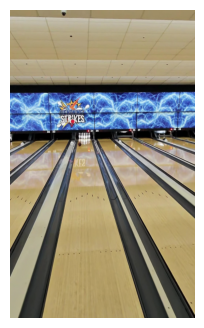

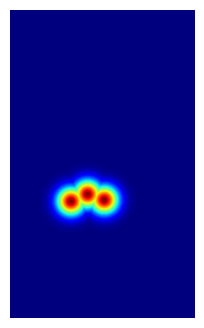

In [47]:
# Dataset sanity check: verifies matching image/heatmap files, checks shapes, and shows a visual sample.

ds = ArrowDataset(str(OUT_IMG_DIR), str(OUT_HM_DIR))
print("Dataset size:", len(ds))

if len(ds) > 0:
    img, hm = ds[0]        # both are torch tensors now

    print("Image shape:", img.shape)      # [3, H, W]
    print("Heatmap shape:", hm.shape)     # [3, H, W]

    import matplotlib.pyplot as plt
    import numpy as np

    # convert image back to HWC for display
    img_np = (img.permute(1,2,0).numpy() * 255).astype(np.uint8)

    # heatmap visualization: max over channels → HWC
    hm_np = hm.numpy()               # CHW
    hm_vis = hm_np.max(axis=0)       # HW
    hm_vis = (hm_vis * 255).astype(np.uint8)

    # show image
    plt.figure(figsize=(6,4))
    plt.imshow(img_np)
    plt.axis("off")
    plt.show()

    # show heatmap
    plt.figure(figsize=(6,4))
    plt.imshow(hm_vis, cmap="jet")
    plt.axis("off")
    plt.show()